This notebook summarises everything I got upto.
[Forked from this one (LB= 65.35)](https://www.kaggle.com/code/ollypowell/enefit-with-filled-nulls-historical-and-forecast?scriptVersionId=160925712)

**Ideas that helped**:
- Experiments with small ensemble that was fast enough to run without GPU resources. It meant I could do loads of experiments, & could automate parameter tuning without any GPU or big time constraints.
- Smaller & faster training with smaller models (that I arrived at with Optuna & internal CV score)
- Splitting the problem up into four cases Business/Home * Production/Consumption
- Training the business cases on all data, the home cases on just home data
- Using all data.  Not sure why the base notebook put a lower limit on the date-time
- Some domain knowledge features
- Adding Estonian Holidays
- Filling nulls in lagged features (inevitable for edge cases) with un-lagged features.
- Combining some correlated features, found using LOFO

**Things that didn't work, or I didn't get quite right**
- Combining even more correlated features.  I need to come up with a more methodical way to do feature selection.
- My CV scheme.  It wasn't corresponding to the leaderboard all that well, and in the last few days it seemed to get inconsistent, but I ran out of time to troubleshoot.
- PCA components.  I should have got onto this much earlier, it's a powerful technique but not left to the last 2 days!
- Feature importance & selection more generally.  I'm going to need to understand this topic a little better, some seemingly unimportant features affected the leaderboard or CV, whilst other seemingly stronger features sent them backwards.  
- Faffing around with weak features.  I would have made more progress just ignoring those initially, focussed on combining correlated features, and working with the high importance features.

Standing on the shoulders of giants, the notebooks below contributed to the baseline I worked from.  Thanks so much for their efforts.   
[This awesome one combining OOP with Polars](https://www.kaggle.com/code/vitalykudelya/enefit-object-oriented-gbdt)  
[Enefit Generic Notebook](https://www.kaggle.com/code/greysky/enefit-generic-notebook)   
[Enefit - lgb with regression_l1 objective](https://www.kaggle.com/code/davero/enefit-lgb-with-regression-l1-objective)  
[Explain Dataset and Baseline](https://www.kaggle.com/code/vitalykudelya/explain-dataset-and-baseline)

In [1]:
import enefit
import warnings
warnings.filterwarnings("ignore")

import os

import numpy as np
import pandas as pd
import polars as pl
import plotly.express as px
import seaborn as sns
from holidays import country_holidays
from datetime import datetime, timedelta

from sklearn.ensemble import VotingRegressor
import lightgbm as lgb
import torch
import time

#might not need some of this:
from tqdm.autonotebook import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [2]:
start_time = time.time()
#Notebook use settings, change as needed
settings={
    'DEBUG': False,  #Really fast, but still with the same functionality, for debugging only
    'EDA': False,   #Add MI scores, plots etc
    'VALIDATION': True, #Data will be split up for train & validation, a validation score will be produced (one fold only)
    'BASELINE': True, #Reduced computation time/performance for experiment submissions
    'TUNE_HYPERPARAMETERS': False,
    'CASES_TO_TUNE': ['biz_production'] #, ['biz_consumption']', ['home_consumption'], ['home_production']
}

# Classes & Helper Functions

In [3]:
class DefaultConfig:
    '''Making settings I might play with transparent'''
    def __init__(self):
        self.debug = False
        self.eda = False
        self.val = False
        self.tune = False
        self.val = False
        self.eval_unscored = False #Set True to process unscored rows, just to stress test for nulls etc.  Set False for final submission.
        self.num_models = 12
        self.model_parameters = None 
        self.to_tune =  ['biz_consumption', 'biz_production', 'home_consumption', 'home_production']  #leave unchanged, and adjust in settings
        self.biz_consumption = {"n_estimators": 800, #From optuna
                                'num_leaves':400,
                                "learning_rate": 0.065}
    
        self.biz_production = {"n_estimators": 950,  #From optuna
                               'num_leaves':690,
                               "learning_rate": 0.065}
    
        self.home_consumption = {"n_estimators": 800,  #From optuna
                                 'num_leaves':400,
                                 "learning_rate": 0.065}
    
        self.home_production = {"n_estimators": 800,  #From optuna
                                'num_leaves':680,
                                "learning_rate": 0.065}



class Names:
    '''Just looking for a tidy way to store all these column names, lists, masks etc.'''
    case_names = ['biz_consumption', 'biz_production', 'home_consumption', 'home_production']
    cat_names_not_feats = ['is_consumption','is_business'] # , #columns that can't be dropped entirely because they are used for masks, 
    worst_features = {'home_consumption':['product_type',
                                          'snowfall_historical_local_168h',
                                          'snowfall_historical_24h', 
                                          'holiday',
                                          'short_d_before_hol',], #['year'],
                      'home_production':['snowfall_historical_local_168h',
                                         'snowfall_historical_local_48h',
                                         'snowfall_historical_24h', 
                                         'sin(weekday)', 
                                         'cos(weekday)',
                                         'product_type', 
                                         'is_work_hours',
                                         'wd_holiday',
                                         'holiday',
                                         'short_d_before_hol', 
                                         'is_weekend'],
                                          #['year', 'weekday'],
                      'biz_consumption': ['product_type',
                                          'snowfall_historical_local_168h',
                                          'snowfall_historical_24h',
                                          'holiday',],
                                          #['year','short_d_before_hol','is_work_hours'],
                      'biz_production': ['snowfall_historical_local_168h',
                                         'snowfall_historical_local_48h',
                                         'snowfall_historical_24h', 
                                         'sin(weekday)', 'cos(weekday)',
                                         'product_type', 
                                         'wd_holiday','holiday', 'short_d_before_hol',
                                         'is_work_hours',
                                         'is_weekend']
                                          #['year'] 
                      }
    feats_to_sum = {'wind': ["10_metre_u_wind_component", "10_metre_v_wind_component", '10_metre_u_wind_component_forecast_local_0h',
                             '10_metre_v_wind_component_forecast_local_0h'],
                    'cloud_high' : ['cloudcover_high_forecast_168h', 'cloudcover_high_historical_168h'],
                    'cloud_low':['cloudcover_low_forecast_168h', 'cloudcover_low_historical_168h'],
                    'cloud_mid':['cloudcover_mid_forecast_168h', 'cloudcover_mid_historical_168h'],}

This notebook really had a lot of derived features, many of them very correlated with each other.  There was probably a lot of room for improvement by analyzing this more methodically. LOFO analysis suggested summing the following features, but when I did that I still got big drop in performance. I ran out of time to investigate further. 

**'radiation'**  
'diffuse_radiation', 'diffuse_radiation_historical_168h', 'diffuse_radiation_historical_local_168h', 'diffuse_radiation_historical_local_48h', 'direct_solar_radiation', 'direct_solar_radiation_forecast_168h', 'direct_solar_radiation_forecast_local_0h', 'direct_solar_radiation_forecast_local_168h', 'direct_solar_radiation_historical_168h',  'direct_solar_radiation_historical_48h', 'direct_solar_radiation_historical_local_168h', 'direct_solar_radiation_historical_local_48h',   'shortwave_radiation', 'shortwave_radiation_historical_168h', 'shortwave_radiation_historical_local_168h', 'shortwave_radiation_historical_local_48h', 'surface_solar_radiation_downwards', 'surface_solar_radiation_downwards_forecast_168h', 'surface_solar_radiation_downwards_forecast_local_0h', 'surface_solar_radiation_downwards_forecast_local_168h',  
**'dew_temp'**  
'dewpoint', 'dewpoint_forecast_local_0h', 'dewpoint_historical_48h', 'dewpoint_historical_local_48h', 'temperature', 'temperature_forecast_local_0h', 'temperature_historical_48h', 'temperature_historical_local_48h'  
**'dew_temp_168'**  
'dewpoint_forecast_168h', 'dewpoint_forecast_local_168h', 'dewpoint_historical_168h', 'dewpoint_historical_local_168h', 'temperature_forecast_168h', 'temperature_forecast_local_168h', 'temperature_historical_168h', 'temperature_historical_local_168h',  
**'target_feats'**  
'target_120h', 'target_144h', 'target_168h', 'target_192h', 'target_216h', 'target_240h', 'target_264h', 'target_288h', 'target_312h', 'target_336h', 'target_72h', 'target_96h', 'target_all_county_type_sum_168h','target_all_county_type_sum_336h', 'target_all_county_type_sum_48h', 'target_all_county_type_sum_72h', 'target_all_type_sum_168h', 'target_all_type_sum_336h', 'target_all_type_sum_48h', 'target_all_type_sum_72h', 'target_mean']

In [4]:
def get_config(settings):
    """Gets an instance of the config class, then makes any changes deemed necessary for the environment or goal"""
    cfg = DefaultConfig()
    
    model_params = {
            "n_estimators": 800, # This is the one that gets used for the CV score calculation, it isn't over-written by the individual case params
            "learning_rate": .065,  #reducing iterations improves accuracy, but requires more iterations
            "colsample_bytree": 0.9,
            "colsample_bynode": 0.6,
            "lambda_l1": 4.0,
            "lambda_l2": 2.2,
            "max_depth":  16,  #prevents growth of very deep trees, to reduce risk of overfitting
            "num_leaves": 400, #increasing improves accuracy at risk of overfitting
            "min_data_in_leaf": 50,
            "objective": "regression_l1",
            "device": 'cpu',
        }  

    if settings['DEBUG']:
        setattr(cfg, 'debug', True)
        model_params['n_estimators'] = 25
        model_params['num_leaves'] = 50
        setattr(cfg, 'num_models', 2)
    if settings['EDA']:
        setattr(cfg, 'eda', True)
        !pip install lofo-importance
    if settings['BASELINE']:
        print('This version will run a baseline model with reduced ensemble')
        setattr(cfg, 'num_models', 2)
    if settings['VALIDATION']:
        print('This version will get cross validation scores')
        setattr(cfg, 'val', True)
    if settings['TUNE_HYPERPARAMETERS']:
        print('This version will run Optuna')
        setattr(cfg, 'tune', True)
        setattr(cfg, 'to_tune', settings['CASES_TO_TUNE'])
        model_params['n_estimators'] = 1500 #will use early stopping
    model_params['device'] = 'gpu' if torch.cuda.is_available() else 'cpu'
    
    cfg.model_parameters = model_params
    #print(cfg.model_parameters)
    return cfg


def get_cv_folds(df, cases=Names.case_names):
    ''' based on:https://www.kaggle.com/code/vincentschuler/enefit-baseline-cross-validation
    Get a test and train split by masking the training data by end-date, by using different dates
    we are effectively creating a number of different folds, whilst trying to avoid data leakage
    that would occur with all these lagged features if we just randomly split out rows like normal'''

    
    fold_names = ['2023-01-01','2023-02-01','2023-03-01','2023-04-01'] #'2023-05-01
    date_dict = {fold_name: fold_name + ' 00:00:00' for fold_name in fold_names}
    train_mask_list = [
                    (df["is_consumption"] == 1),
                    (df["is_consumption"] == 0),
                    ((df["is_consumption"] == 1) & (df["is_business"] == 0)),
                    ((df["is_consumption"] == 0) & (df["is_business"] == 0))
                    ]
    
    val_mask_list = [
                    ((df["is_consumption"] == 1) & (df["is_business"] == 1)),
                    ((df["is_consumption"] == 0) & (df["is_business"] == 1)),
                    ((df["is_consumption"] == 1) & (df["is_business"] == 0)),
                    ((df["is_consumption"] == 0) & (df["is_business"] == 0))
                    ]
    
    all_train_masks = {name:mask for name, mask in zip(Names.case_names, train_mask_list)}
    train_masks = {key: all_train_masks[key] for key in cases}
    
    all_val_masks = {name:mask for name, mask in zip(Names.case_names, val_mask_list)}
    val_masks = {key: all_val_masks[key] for key in cases}
    
    df_index = df.index
    fold_masks = {
        fold_name: df['datetime'].le(pd.to_datetime(limiting_date))
        for fold_name, limiting_date in date_dict.items()
    }
    
    fold_dict = {}
    for fold_name in fold_names:
        case_dict = {}
        for case_nm in cases:
            df_train_case = df[train_masks[case_nm]]
            df_val_case = df[val_masks[case_nm]]
            df_train = df_train_case.drop(columns=['datetime']).loc[fold_masks[fold_name]]
            df_val = df_val_case.drop(columns=['datetime']).loc[~fold_masks[fold_name]]
            case_dict[case_nm] = [df_train, df_val] 
        fold_dict[fold_name] = case_dict
    
    return fold_dict #32 dataframes [four folds {4 segment cases: [df_train, df_val] }]


def get_data_groups(df_features):
    df=df_features.copy()
    masks = [
            ((df["is_consumption"] == 1) & (df["is_business"] == 1)),
            ((df["is_consumption"] == 0) & (df["is_business"] == 1)),
            ((df["is_consumption"] == 1) & (df["is_business"] == 0)),
            ((df["is_consumption"] == 0) & (df["is_business"] == 0))
            ]
    names = ['biz_consumption', 'biz_production', 'home_consumption', 'home_production']
    groups = {}
    for mask, name in zip(masks,names):
        # Combine the category columns into a single identifier column
        df['county-type'] = df['county'].astype(str) + '_' + df['product_type'].astype(str)
        groups[name] = df[mask].drop(columns=['is_consumption', 'is_business', 'county', 'product_type'])
    return groups


def make_mi_scores(df): 
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    X = df.copy()
    
    y = X.pop("target")
    #for colname in X.select_dtypes(["object", "category"]):
    #    X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    plt.figure(figsize=(10, 35))
    sns.barplot(x=scores.values, y=scores.index, orient='h')
    plt.title("Mutual Information Scores")
    plt.show()   

Generate a holiday calender

In [5]:
def get_calender():
    '''A function to generate a calender for special days, like holidays, or days before holidays'''
    def modify_label(row):
        if row["holiday"] == 1:
            return row["holiday"] + 1
        else:
            return row["holiday"]
    
    days_off=['uusaasta', 
              'iseseisvuspäev', 
              'suur reede', 
              'kevadpüha', 
              'võidupüha', 
              'jaanipäev', 
              'taasiseseisvumispäev',
              'jõululaupäev',
              'esimene jõulupüha'
              'teine jõulupüha']
    
    day_before_short = ['uusaasta','iseseisvuspäev', 'võidupüha', 'jõululaupäev']
    #The working day preceeding New Year’s Day, the anniversary of the Republic of 
    #Estonia, Victory Day, and Christmas Eve is shortened by three hours.  
    # Consider school holidays?
    
    holiday_data = []
    start_year = 2021
    end_year = 2026
    col_order=['date', 'name', 'holiday']
    for year in range(start_year, end_year, 1):
        estonian_holidays = country_holidays('EE', years=year)
        holiday_data.extend([{"date": d, "name": name, "holiday": 1} for d, name in estonian_holidays.items()])
    names = set([item['name'] for item in holiday_data])
    df_holidays = pl.DataFrame(holiday_data)
    df_holidays = df_holidays.with_columns(pl.col("date").cast(pl.Date))
    df_holidays = df_holidays.with_columns(pl.col('holiday').cast(pl.Int32))
    
    
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year-1, 12, 31)
    date_objects = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]
    df_all = pl.DataFrame({"date": date_objects}).with_columns(pl.col('date').cast(pl.Date))
    df_all = df_all.with_columns(pl.lit(0).alias("holiday"))
    df_all = df_all.with_columns(pl.lit('no_holiday').alias("name"))
    df_no_hol = df_all.join(df_holidays, on="date", how='anti').select(pl.col(col_name) for col_name in col_order)
    df_calender = pl.concat([df_no_hol, df_holidays])

    # Sort the DataFrame by the "date" column
    df_calender = df_calender.sort("date")
    df_calender = df_calender.with_columns(pl.col('date').dt.weekday().alias('weekday'))
    df_calender = df_calender.with_columns((pl.col('weekday').is_in([1,2,3,4,5]) & (pl.col('holiday')==1)).cast(pl.Int8).alias('wd_holiday'),
                                            pl.when((pl.col('holiday') == 0) 
                                                    & (pl.col('holiday').shift(-1) == 1)
                                                    & (pl.col('weekday').is_in([1,2,3,4,5]))
                                                    & (pl.col('name').shift(-1).is_in(day_before_short)
                                                      )).then(1).otherwise(0).alias('short_d_before_hol'), #feature for short weekdays before some holidays
                                            pl.when((pl.col('holiday') == 0) 
                                                    & (pl.col('holiday').shift(-1) == 1)
                                                    & (pl.col('weekday').is_in([1,2,3,4]))
                                                    & (pl.col('name').shift(-1).is_in(day_before_short).is_not()
                                                      )).then(1).otherwise(0).alias('normal_d_before_hol'), #feature for weekdays before other weekday holidays
                                            pl.when((pl.col('holiday') == 0) 
                                                    & (pl.col('holiday').shift(+1) == 1)
                                                    & (pl.col('weekday').is_in([2,3,4,5])))
                                                      .then(1).otherwise(0).alias('d_after_hol') #feature for weekdays after weekday holidays
                                          )
    df_calender = df_calender.drop(['name','weekday','normal_d_before_hol', 'd_after_hol'])#,'short_d_before_hol', 'normal_d_before_hol', 'd_after_hol' 'wd_holiday'
    df_calender = df_calender.fill_null(0)
    return df_calender

df_calender = get_calender()
df_calender.tail(5)

date,holiday,wd_holiday,short_d_before_hol
date,i32,i8,i32
2025-12-27,0,0,0
2025-12-28,0,0,0
2025-12-29,0,0,0
2025-12-30,0,0,0
2025-12-31,0,0,0


### DataStorage

In [6]:
class DataStorage:
    root = "/kaggle/input/predict-energy-behavior-of-prosumers"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
        #"data_block_id"
    ]
    
    #client_basics = ["product_type","county", "is_business", "eic_count", "installed_capacity"]
    #client_cols = client_basics + ['date']#, 'data_block_id']
    #client_cols_datetime = client_basics + ['datetime', 'is_consumption'] #, 'client_data_block_id'] #so it can later be joined the same way as other features
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]    

    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",  ###
        "dewpoint",  ###
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total", ###
        "cloudcover_low", ###
        "cloudcover_mid", ###
        "cloudcover_high", ###   matches with forecast cols:  ["temperature", "dewpoint",  "cloudcover_total", "cloudcover_low",  "cloudcover_mid",  "cloudcover_high", "snowfall"]
        "windspeed_10m",    # no match: ["rain", "surface_pressure", "windspeed_10m", "winddirection_10m", "shortwave_radiation", "direct_solar_radiation", "diffuse_radiation"]
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
            "target",
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "datetime",
        ]
    

    def __init__(self):
        self.df_calender = get_calender()
        
        _df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        
        
        
        _df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        
        _df_client_future = _df_client.with_columns((pl.col("date") - pl.duration(days=2)))
        #The point is to fill nulls with values from two days behind, because in feature generation we shift the old vals forward to match the new target (+ 2 days)
        #Which will leave an edge case of nulls at the beginning of the dataset
        _df_client = _df_client.join(_df_client_future, on=["date", "county", "is_business", "product_type"], how="left", suffix="_future")

        self.df_client= (_df_client.with_columns(pl.when(pl.col("installed_capacity") <= 0)
                                                    .then(1000)
                                                    .otherwise(pl.col('installed_capacity'))
                                                    .fill_null(pl.col('installed_capacity_future'))
                                                    .fill_nan(1000)
                                                    .fill_null(1000)
                                                    .cast(pl.Float32)
                                                    .alias('installed_capacity') #seems to be needed, or we just get an extra column named 'literal'
                                                    )
                                        .drop('installed_capacity_future', 'eic_count_future')
                        )

        
        print(self.df_client.head())
        _df_data = _df_data.with_columns((pl.col("datetime")).alias('date').cast(pl.Date))
        _df_capacity = self.df_client.select(["county", "is_business", "product_type", "installed_capacity", "date"])
        _df_data = _df_data.join(_df_capacity, on=["county","is_business", "product_type", "date"], how="left")
        _df_data = _df_data.with_columns((pl.col("target")/pl.col("installed_capacity")).alias('s_target').cast(pl.Float32))
        _df_data = _df_data.drop(['date','installed_capacity', 'target' ])
        self.df_data = _df_data.rename({'s_target':'target'}).select(self.data_cols)
                        
        
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        #self.df_data = self.df_data.filter(
        #    pl.col("datetime") >= pd.to_datetime("2022-01-01")
        #)   #Removed in fork of V70
        
        self.df_target = self.df_data.select(self.target_cols)
        
        self.schema_calender = self.df_calender.schema
        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )


    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
  
        
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_client_future = self.df_client.with_columns(pl.col("date") - pl.duration(days=2))      
        df_new_client = df_new_client.join(df_new_client_future, on=["county", "is_business", "product_type", "date"], how='left', suffix="_future")
        
        df_new_client = (df_new_client.with_columns(pl.when(pl.col("installed_capacity") <= 0)
                                                    .then(1000)
                                                    .otherwise(pl.col('installed_capacity'))
                                                    .fill_null(pl.col('installed_capacity_future'))
                                                    .fill_nan(1000)
                                                    .fill_null(1000)
                                                    .cast(pl.Float32)
                                                    .alias('installed_capacity')
                                                   )
                                        .drop('installed_capacity_future', 'eic_count_future')# or .select(self.client_cols)
                        ) 
        
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target   
        ).with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
        df_new_capacity = df_new_client.select(["county", "is_business", "product_type", "installed_capacity", "date"])
        df_new_target = df_new_target.join(df_new_capacity, on=["county","is_business", "product_type", "date"], how="left")
        df_new_target = df_new_target.with_columns((pl.col("target")/pl.col("installed_capacity")).alias('s_target').cast(pl.Float32))
        df_new_target = df_new_target.drop(['date','installed_capacity', 'target'])
        target_cols = ["target","county", "is_business", "product_type", "is_consumption", "datetime"]
        df_new_target = (df_new_target.rename({'s_target':'target'})).select(self.target_cols)

        
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        
        self.df_client = pl.concat([self.df_client, df_new_client]).unique(["date", "county", "is_business", "product_type"])

        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

### FeaturesGenerator

In [7]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        work_hours = [9,19,11,12,12,14,15,16,17]
        work_days = [1,2,3,4,5]
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"), 
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
                (np.pi * pl.col("weekday") / 7).sin().alias("sin(weekday)"),  ##Added version 5
                (np.pi * pl.col("weekday") / 7).cos().alias("cos(weekday)"),  ##Added version 5
                (pl.col('weekday').is_in([6,7])).alias("is_weekend"),
                (pl.col('hour').is_in(work_hours) & (pl.col('day').is_in(work_days))).cast(pl.Int8).alias("is_work_hours"),
            )
        )
        return df_features
    
    def _add_client_features(self, df_features):
        '''Adds the installed capacity and eic count, but shifted, so I have filled the nulls on the future edge case with the unshifted column'''
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date) 
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        
        
        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date")).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left", suffix='_unshifted'
        ) 
        
        df_features = df_features.with_columns(
                        pl.when(pl.col("installed_capacity")<= 0)
                            .then(1000)
                            .otherwise(pl.col('installed_capacity')
                            .fill_null(pl.col('installed_capacity_unshifted'))
                            .fill_null(1000))
                            .cast(pl.Float32)
                            .alias('_capacity'),
                         pl.col("eic_count")
                            .fill_null(pl.col("eic_count_unshifted"))
                            .fill_null(1000)
                            .cast(pl.Int64)
                            .alias('_eic'))
        
        df_features = (df_features
                       .drop(['installed_capacity', 'eic_count', 'eic_count_unshifted', 'installed_capacity_unshifted'])
                       .rename({'_capacity':'installed_capacity', '_eic':'eic_count'})
                      ) 
        
        #update the stored df_client for use with other features - removes the is_consumption rows
        self.df_client = (df_features.select(df_client.columns)
                          .groupby(['date', "county", "is_business", "product_type"])
                          .agg(pl.col('installed_capacity').first(), pl.col('eic_count').first())
                         )

        print(f'length after adding client feats {len(df_features)}')
        
        return df_features
    
    
    def _add_calender_features(self, df_features):
        df_calender = self.data_storage.df_calender
        df_features = df_features.join(df_calender, on='date', how='left')
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather.with_columns(
                pl.col("total_precipitation").clip(lower_bound=0),
                pl.col("direct_solar_radiation").clip(lower_bound=0),
                pl.col("surface_solar_radiation_downwards").clip(lower_bound=0)
                )
        
        
        
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )
        
        
        df_pv_performance = (df_forecast_weather.select(['county', 'datetime', 'temperature', 'surface_solar_radiation_downwards'])
                                .with_columns((pl.col('surface_solar_radiation_downwards')/(pl.col('temperature')+273))
                                      .cast(pl.Float32)
                                      .alias('pv_performance')
                                      )
                                 .drop(['temperature', 'surface_solar_radiation_downwards'])
                                 .groupby(['county', 'datetime'])
                                 .agg(pl.col('pv_performance').mean())
                                )
        
        df_features = df_features.join(df_pv_performance, on=['county', 'datetime'], how='left')
        

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )
        
        
        for hours_lag in [0, 7 * 24]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )

            
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )
        
        #fill nulls resulting from the edge case when lagging features, note that the 0h forcast data doesn't get a suffix.  This should really be fixed up.
        weather_cols = [ "dewpoint", "cloudcover_high", "cloudcover_low",  "cloudcover_mid", "cloudcover_total", 
                        "10_metre_u_wind_component", "10_metre_v_wind_component", "direct_solar_radiation", 
                        "surface_solar_radiation_downwards", "snowfall",  "total_precipitation", ]
        

        
        for col in weather_cols:
            df_features = df_features.with_columns(pl.col(f'{col}_forecast_local_168h').fill_null(pl.col(f'{col}_forecast_local_0h')),
                                                   pl.col(f'{col}_forecast_168h').fill_null(pl.col(col))
            )
        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )
        
        #These columns will automatically get a suffix for the 48hr lag feature,  the others won't.
        cols_with_name_clash = ["temperature", "dewpoint",  "cloudcover_total", "cloudcover_low",  "cloudcover_mid",  "cloudcover_high", "snowfall"]
        cols_with_no_name_clash = ["rain", "surface_pressure", "windspeed_10m", "winddirection_10m", "shortwave_radiation", "direct_solar_radiation", "diffuse_radiation"]
        
        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )
            
        #fill nulls for the 168 hr lagged features edge cases
        for col in cols_with_name_clash:
            df_features = df_features.with_columns(pl.col(f'{col}_historical_168h').fill_null(pl.col(f'{col}_historical_48h')),
                                                   pl.col(f'{col}_historical_local_168h').fill_null(pl.col(f'{col}_historical_local_48h'))
            )
            
        for col in cols_with_no_name_clash:
            df_features = df_features.with_columns(pl.col(f'{col}_historical_168h').fill_null(pl.col(col)),
                                                   pl.col(f'{col}_historical_local_168h').fill_null(pl.col(f'{col}_historical_local_48h'))
            )
            

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target
        
        
        
        _df_mean_max_production = (df_target
                                    .select(['is_business', 'product_type', 'county', 'is_consumption', 'datetime', 'target'])
                                    .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
                                    .group_by(['is_business', 'product_type', 'county', 'is_consumption', 'date'])
                                    .agg(pl.col('target').max().suffix('_p_max'))
                                    .filter(pl.col('target_p_max').is_null() | pl.col('is_consumption')==0)
                                    .group_by(['is_business', 'product_type', 'county'])
                                    .agg(pl.col('target_p_max').mean().suffix('_mean'))
                                    .drop('target_p_max', 'target', 'date', 'datetime', 'is_consumption')
                                  )
        
        _df_mean_max_consumption = (df_target
                                    .select(['is_business', 'product_type', 'county', 'is_consumption', 'datetime', 'target'])
                                    .with_columns(pl.col("datetime").cast(pl.Date).alias("date"))
                                    .group_by(['is_business', 'product_type', 'county', 'is_consumption', 'date'])
                                    .agg(pl.col('target').max().suffix('_c_max'))
                                    .filter(pl.col('target_c_max').is_null() | pl.col('is_consumption')==1)
                                    .group_by(['is_business', 'product_type', 'county'])
                                    .agg(pl.col('target_c_max').mean().suffix('_mean'))
                                    .drop('target_c_max', 'target', 'date', 'datetime', 'is_consumption')
                                  )
        
        _pv_use_ratio = (_df_mean_max_production.join(_df_mean_max_consumption, on = ['is_business', 'product_type', 'county'], how = 'left')            
                                     .with_columns(((pl.col('target_p_max_mean').fill_null(strategy='mean'))/
                                                 ((pl.col('target_c_max_mean').fill_null(strategy='mean'))
                                                     .clip(lower_bound=0.01))).alias('p_c_ratio')))
        
        _consumption_per_house = (self.df_client
                                  .drop(['installed_capacity'])
                                  .join(_df_mean_max_consumption, on = ['is_business', 'product_type', 'county'], how = 'left')
                                  .with_columns(((pl.col('target_c_max_mean').fill_null(strategy='mean'))/
                                                 ((pl.col('eic_count').fill_null(strategy='mean'))
                                                     .clip(lower_bound=1))).cast(pl.Float32).alias('cons_per_house'))
                                  .drop(['eic_count', 'target_c_max_mean'])
                                 )
        
        _production_per_house = (self.df_client
                                 .drop(['installed_capacity'])
                                 .join(_df_mean_max_production, on = ['is_business', 'product_type', 'county'], how = 'left')
                                  .with_columns(((pl.col('target_p_max_mean').fill_null(strategy='mean'))/
                                                 ((pl.col('eic_count').fill_null(strategy='mean'))
                                                     .clip(lower_bound=1))).cast(pl.Float32).alias('prod_per_house'))
                                 .drop(['eic_count', 'target_p_max_mean'])
                                )
        
        
        
        
        
        df_features = df_features.join(_pv_use_ratio, on = ['is_business', 'product_type', 'county'], how='left')
        df_features = df_features.join(_consumption_per_house, on = ['is_business', 'product_type', 'county', 'date'], how='left')
        df_features = df_features.join(_production_per_house, on = ['is_business', 'product_type', 'county', 'date'], how='left')
        
        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )
        
        df_target_means = df_target.group_by(["is_business", "product_type", 'is_consumption', "county"]).agg(pl.col("target").mean().suffix('_mean'))
        df_target_sum_means = df_target_all_type_sum.groupby(["is_business", 'is_consumption', "county"]).agg(pl.col("target").mean().suffix('_sum_all_type_mean'))
        df_all_type_sum_means = df_target_all_county_type_sum.groupby(["is_business", 'is_consumption']).agg(pl.col("target").mean().suffix('_sum_all_type_county_mean'))
        
        df_features = df_features.join(df_target_means, on=(["is_business", "product_type", 'is_consumption', "county"]), how='left')
        df_features = df_features.join(df_target_sum_means, on=(["is_business", 'is_consumption', "county"]), how='left')
        df_features = df_features.join(df_all_type_sum_means, on=(["is_business", 'is_consumption',]), how='left')
        
        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                )
                .rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )
        
        
        
        
        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                    
                )
                .rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )
            
            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                )
                .rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )
            
            #fill_nulls
            df_features = df_features.with_columns(
                pl.col(f"target_{hours_lag}h").fill_null(pl.col('target_mean')),
                pl.col(f"target_all_type_sum_{hours_lag}h").fill_null(pl.col('target_sum_all_type_mean')),
                pl.col(f"target_all_county_type_sum_{hours_lag}h").fill_null(pl.col('target_sum_all_type_county_mean')),
            )
               
        #Try making a target from target_48h  'surface_pressure', & 'surface_pressure_historical_local_48h'
        #df_features = df_features.with_columns((pl.col('target_48h') / pl.col('surface_pressure')).alias('targ_pressure_48h'),
        #                                      (pl.col('target_48h') / pl.col('surface_pressure_historical_local_48h')).alias('targ_pressure_local_48h')
        #                                      )
             
        df_features = df_features.drop(['target_mean','target_sum_all_type_mean','target_sum_all_type_county_mean'])
        
        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )   
            
        print(f'length after adding target feats {len(df_features)}')
        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date",  "hour", "dayofyear"  #"datetime",  #needed for train/val splitting
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
            "holiday",
            "wd_holiday",
            'short_d_before_hol',
            "is_weekend",
            'is_work_hours',
        ]

        
        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()
            
        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    
    def _sum_correlated(self, df_features):
        for (new_nm, feat_names) in Names.feats_to_sum.items():
            sum_expression = pl.col(feat_names[0])
            for column_name in feat_names[1:]:
                sum_expression += pl.col(column_name)
            df_features = df_features.with_columns(sum_expression.alias(new_nm))#.drop(feat_names)
        return df_features
    
    def _get_pca_features(self, df_features):
        
        features = ['surface_pressure_historical_local_168h', 'target_168h', 'target_144h',
                    'dewpoint_forecast_local_0h', 'temperature_forecast_local_0h','target_mean',
                    'dewpoint']
        
        X = df_features.loc[:,features].copy()
        
        #handle potential nulls and divid by 0
        if X.isnull().any().any():
            X = X.fillna(X.mean())
        std_values = X.std(axis=0)
        if (std_values == 0).any():
            std_values[std_values == 0] = 1e3
    
        X = (X - X.mean(axis=0)) / std_values
        X['pc1'] = (0.53 * (X['target_168h'] + X['target_144h'] + X['target_mean'])
                    - 0.16 * (X['dewpoint_forecast_local_0h'] + X['temperature_forecast_local_0h'] + X['dewpoint'])) # MI 0.62  
        X['pc2'] = -0.54 * X['target_168h'] + 0.8 * X['target_144h'] - 0.26 * X['target_mean']    # MI 0.47  
        X['pc3'] = -0.61 * X['target_168h'] - 0.15 * X['target_144h'] + 0.77 * X['target_mean']  # MI 0.36  
        
        new_features = ['pc1', 'pc2', 'pc3']
        df_features = pd.merge(df_features, X[new_features], left_index=True, right_index=True)
        return df_features
    
    def _remove_summed_features(self, df_features):
        summed_features = list(set(item for sublist in Names.feats_to_sum.values() for item in sublist))
        to_drop = set(df_features.columns).intersection(summed_features)
        #missing_columns = set(df_features.columns).difference(df_features.columns)
        #print(missing_columns)
        df_features = df_features.drop(columns=to_drop)
        return df_features
    
    
    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        if cfg.debug:
            df_prediction_items.head(1000).write_csv('df_prediction_items.csv')
            #self.data_storage.df_target.head(1000).write_csv('df_target.csv')
            
        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_calender_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)
        
        print(f'Features shape after adding polars features: {df_features.shape}')
        
        if not cfg.eda:
            df_features = self._sum_correlated(df_features)  
        print(f'Features shape after adding summing correlated columns: {df_features.shape}')
        
        df_features = self._to_pandas(df_features, y)
        
        if not cfg.eda:
            #df_features = self._get_pca_features(df_features)
            #print(f'Features shape after adding PCA features: {df_features.shape}')
            df_features = self._remove_summed_features(df_features)  
        print(f'Features shape after dropping correlated columns: {df_features.shape}')
            
        return df_features


### Model

In [8]:
class Model:
    def __init__(self, new_parameters=None, num_to_drop=0):
        self.num_to_drop = num_to_drop
        
        if new_parameters is None:
            self.model_parameters = cfg.model_parameters
        else:
            self.model_parameters = cfg.model_parameters.copy()
            self.model_parameters.update(new_parameters)
        
        self.biz_cons_params = self.model_parameters.copy()
        self.biz_prod_params = self.model_parameters.copy()
        self.home_cons_params = self.model_parameters.copy()
        self.home_prod_params = self.model_parameters.copy()
        
        if not(cfg.debug or cfg.tune):
            self.biz_cons_params.update(cfg.biz_consumption)
            self.biz_prod_params.update(cfg.biz_production)
            self.home_cons_params.update(cfg.home_consumption)
            self.home_prod_params.update(cfg.home_production)
            
        print(f"n_estimators for biz_consumption:{self.biz_cons_params['n_estimators']}")
        print(f"n_estimators for biz_production:{self.biz_prod_params['n_estimators']}")
        print(f"n_estimators for home_consumption:{self.home_cons_params['n_estimators']}")
        print(f"n_estimators for home_consumption:{self.home_prod_params['n_estimators']}")

        print(f"num_leaves for biz_consumption:{self.biz_cons_params['num_leaves']}")
        print(f"num_leaves for biz_production:{self.biz_prod_params['num_leaves']}")
        print(f"num_leaves for home_consumption:{self.home_cons_params['num_leaves']}")
        print(f"num_leaves for home_consumption:{self.home_prod_params['num_leaves']}")
        
        
        self.model_consumption_biz = VotingRegressor(
            [(f"consumption_bus_lgb_{i}",lgb.LGBMRegressor(**self.biz_cons_params, random_state=i))
             for i in range(cfg.num_models)])  #Could be increased relative to the others as this case is the largest source of error.
        
        self.model_production_biz = VotingRegressor(
            [(f"production_bus_lgb_{i}",lgb.LGBMRegressor(**self.biz_prod_params, random_state=i)) 
             for i in range(cfg.num_models)])
        
        self.model_consumption_home = VotingRegressor(
            [(f"consumption_home_lgb_{i}",lgb.LGBMRegressor(**self.home_cons_params, random_state=i))
             for i in range(cfg.num_models)])
        
        self.model_production_home = VotingRegressor(
            [(f"production_home_lgb_{i}", lgb.LGBMRegressor(**self.home_prod_params, random_state=i))
            for i in range(cfg.num_models)])
        
        self.models = [
            self.model_consumption_biz,
            self.model_production_biz,
            self.model_consumption_home,
            self.model_production_home
        ]

        self.fit_params = {"eval_metric" : 'mean_absolute_error',
                           "eval_names": ['train', 'test'],
                           "categorical_feature": 'auto'}
        
         
        self.cv_model_consumption_biz = lgb.LGBMRegressor(**self.model_parameters)
        self.cv_model_production_biz = lgb.LGBMRegressor(**self.model_parameters) 
        self.cv_model_consumption_home = lgb.LGBMRegressor(**self.model_parameters)
        self.cv_model_production_home = lgb.LGBMRegressor(**self.model_parameters)
        
        self.cv_models= [
            self.cv_model_consumption_biz,
            self.cv_model_production_biz,
            self.cv_model_consumption_home,
            self.cv_model_production_home
            ]
        
    def fit(self, df_train_features):
        
        masks = [
            (df_train_features["is_consumption"] == 1),
            (df_train_features["is_consumption"] == 0),
            ((df_train_features["is_consumption"] == 1) & (df_train_features["is_business"] == 0)),
            ((df_train_features["is_consumption"] == 0) & (df_train_features["is_business"] == 0))
        ]
        
        for mask, model, case_name in zip(masks, self.models, Names.case_names):
            cols_to_drop = Names.worst_features[case_name]
            df_train_feats = df_train_features.drop(columns=cols_to_drop)
            model.fit(
            X=df_train_feats[mask].drop(columns=["target", "datetime"]  + Names.cat_names_not_feats),
            y=df_train_feats[mask]["target"] #- df_train_feats[mask]["target_48h"].fillna(0)
            )
            
    def fit_with_cv(self, train_val_folds, early_stopping=False):  #assume 32 dataframes [four folds {4 segment cases: [df_train, df_val] }]
        '''Currently this does not use any of the individualised case parameters, just the ones passed to the init, (from  tuning)'''
        
        fit_params = {"eval_metric" : 'mean_absolute_error',
              "eval_names": ['train', 'val'],
              "categorical_feature": 'auto'}
        
        results = {}
        all_scores = []
        case_scores_fold = {}
        for index, (fold_nm, case_dict) in enumerate(train_val_folds.items()): 
            case_list = list(case_dict.keys())
            iterations = []
            fold_scores = []
            
            case_estimators = {}
            val_sample_num = {}
            for (case_nm, train_val), model in zip(case_dict.items(), self.cv_models):
                '''fit each of the four model case for this split'''
                train_df = train_val[0]
                val_df = train_val[1]

                extra_cols_to_drop = Names.worst_features[case_nm]
                
                X_train = train_df.drop(columns=(["target"] + Names.cat_names_not_feats))
                X_train = X_train.drop(columns=extra_cols_to_drop)
                y_train = train_df["target"] #- train_df['target_48h']
                
                X_val= val_df.drop(columns=(["target"] + Names.cat_names_not_feats))
                X_val = X_val.drop(columns=extra_cols_to_drop)
                y_val= val_df["target"] #- val_df['target_48h'] 
                val_sample_num[case_nm] = len(X_val)
                
                feature_list = X_train.columns.tolist()
                fit_params['eval_set'] = [(X_train, y_train), (X_val, y_val)]
                if early_stopping:
                    callbacks = [lgb.early_stopping(15, verbose=False),lgb.log_evaluation(0)]
                else:
                    callbacks= [lgb.log_evaluation(0)]
                
                if not cfg.tune:
                    n_estimators = self.model_parameters['n_estimators']
                    print(f'Getting CV with {n_estimators} estimators')
                model.fit(X_train, y_train, **fit_params, callbacks=callbacks)
                    
                iterations.append(model.best_iteration_)
                capacity_values = val_df['installed_capacity'].values
                capacity_values[np.isnan(capacity_values)] = 1000 #This line shouldn't really be needed
                preds = np.clip(model.predict(X_val), 0, 15000)    # + X_val["target_48h"].fillna(0).values
                score = round(mean_absolute_error(y_val*capacity_values, preds*capacity_values),2)
                fold_scores.append(score)
                print(iterations, fold_scores)
                case_scores_fold[case_nm] = case_scores_fold.get(case_nm,[]) + [score] # a dic of lists of fold scores by case
                
                if early_stopping:
                    case_estimators[case_nm] = case_scores_fold.get(case_nm,[]) + [model.best_iteration_]
                
                if (not cfg.tune) and (index==0):
                    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, feature_list)), columns=['Value','Feature'])
                    feature_imp['Value'] = 100* (feature_imp['Value'] / feature_imp['Value'].max()) # Normalisation
                    feature_imp = feature_imp.sort_values(by='Value', ascending=False).reset_index(drop=True)
                    print(f'The 50 least useful features from best to worste for {case_nm}')
                    print(feature_imp['Feature'].to_list()[-50:])
                    
                    if len(feature_imp) > 90 : plt.figure(figsize=(7,30))
                    elif len(feature_imp) > 60 : plt.figure(figsize=(7, 12))
                    elif len(feature_imp) > 30 : plt.figure(figsize=(7, 10))
                    else: plt.figure(figsize=(5, 5))
                    
                    sns.barplot(x="Value", y="Feature", data=feature_imp)  #.head(100)
                    plt.title(f'Features Importance for {case_nm}')
                    plt.show()

            results[fold_nm] = (iterations, fold_scores)
            total_val = sum(val_sample_num.values())
            balance_val = {case_nm : val_sample_num[case_nm]/total_val for case_nm in case_list}
            print(balance_val)
            fold_score_balanced = sum([case_scores_fold[case_nm][0]*balance_val[case_nm] for case_nm in case_list])
            all_scores.extend([fold_score_balanced])
            print(results)
        
        for case_nm in case_list:
            fold_scores = case_scores_fold[case_nm]
            mean_score = round(sum(fold_scores)/len(fold_scores),2)
            print(f'mean score for {case_nm}: {mean_score}')
            if early_stopping:
                print(f'iterations by fold for {case_nm}: {case_estimators[case_nm]}')
                print(f'mean iterations for case{case_nm}: {round(sum(case_estimators[case_nm])/len(case_estimators[case_nm]),2)}')
        cv = sum(all_scores)/len(all_scores)
        print(f'The cross validation score is {round(cv,2)}')
        
        return cv
                
                     
    def predict(self, df_features):
        predictions = np.zeros(len(df_features), dtype=np.float64)
        df_capacity = df_features["installed_capacity"]
        df_features = df_features.drop(columns=['datetime'])
        masks = [
            ((df_features["is_consumption"] == 1) & (df_features["is_business"] == 1)),
            ((df_features["is_consumption"] == 0) & (df_features["is_business"] == 1)),
            ((df_features["is_consumption"] == 1) & (df_features["is_business"] == 0)),
            ((df_features["is_consumption"] == 0) & (df_features["is_business"] == 0))
        ]
    
        for mask, model, case_name in zip(masks, self.models, Names.case_names):
            capacity_values = df_capacity[mask].values
            capacity_values[np.isnan(capacity_values)] = 1000 #This line shouldn't really be needed
            cols_to_drop = Names.worst_features[case_name]
            df_feats = df_features.drop(columns=cols_to_drop)
            
            preds = model.predict(df_feats[mask].drop(columns=Names.cat_names_not_feats)) # + df_feats[mask]["target_48h"].fillna(0).values
            predictions[mask.values] = (preds * capacity_values).clip(0) 
        
        return predictions

# Initialisation

In [9]:
cfg = get_config(settings)
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)
if cfg.debug:
    print(f'Running in Debug Mode')

This version will run a baseline model with reduced ensemble
This version will get cross validation scores
shape: (5, 6)
┌──────────────┬────────┬───────────┬────────────────────┬─────────────┬────────────┐
│ product_type ┆ county ┆ eic_count ┆ installed_capacity ┆ is_business ┆ date       │
│ ---          ┆ ---    ┆ ---       ┆ ---                ┆ ---         ┆ ---        │
│ i64          ┆ i64    ┆ i64       ┆ f32                ┆ i64         ┆ date       │
╞══════════════╪════════╪═══════════╪════════════════════╪═════════════╪════════════╡
│ 1            ┆ 0      ┆ 108       ┆ 952.890015         ┆ 0           ┆ 2021-09-01 │
│ 2            ┆ 0      ┆ 17        ┆ 166.399994         ┆ 0           ┆ 2021-09-01 │
│ 3            ┆ 0      ┆ 688       ┆ 7207.879883        ┆ 0           ┆ 2021-09-01 │
│ 0            ┆ 0      ┆ 5         ┆ 400.0              ┆ 1           ┆ 2021-09-01 │
│ 1            ┆ 0      ┆ 43        ┆ 1411.0             ┆ 1           ┆ 2021-09-01 │
└──────────────┴───

## EDA of original data

In [10]:
data_df = data_storage.df_data
data_df.head()

target,county,is_business,product_type,is_consumption,datetime,row_id
f32,i64,i64,i64,i64,datetime[μs],i64
0.000748,0,0,1,0,2021-09-01 00:00:00,0
0.101365,0,0,1,1,2021-09-01 00:00:00,1
0.0,0,0,2,0,2021-09-01 00:00:00,2
0.10405,0,0,2,1,2021-09-01 00:00:00,3
0.000403,0,0,3,0,2021-09-01 00:00:00,4


It seems harder to predict the business consumption,  I would like to look at the relative size of the training data avaiable for different cases

In [11]:
data_df.groupby(["is_business"]).agg(pl.count())

is_business,count
i64,u32
0,934848
1,1083504


In [12]:
target_df = data_storage.df_target
target_df.head(5)

target,county,is_business,product_type,is_consumption,datetime
f32,i64,i64,i64,i64,datetime[μs]
0.000748,0,0,1,0,2021-09-01 00:00:00
0.101365,0,0,1,1,2021-09-01 00:00:00
0.0,0,0,2,0,2021-09-01 00:00:00
0.10405,0,0,2,1,2021-09-01 00:00:00
0.000403,0,0,3,0,2021-09-01 00:00:00


In [13]:
import matplotlib.pyplot as plt
if cfg.eda:
    df_data = data_storage.df_data
    production_df = data_storage.df_data.filter((df_data["is_consumption"] == 0) | (df_data['product_type']==3)).to_pandas()
    production_df['time_of_day'] = production_df['datetime'].dt.hour

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='time_of_day', y='target', data=production_df)
    plt.title('Target Distribution by Time of Day')
    plt.xlabel('Time of Day (Hour)')
    plt.ylabel('Target')
    plt.show()
    df_data
    night_production_df = production_df[(production_df['datetime'].dt.hour.between(21, 23)) | (production_df['datetime'].dt.hour.between(0,4))]
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='time_of_day', y='target', data=night_production_df)
    plt.title('Target Distribution by Time of Day')
    plt.xlabel('Time of Day (Hour)')
    plt.ylabel('Target')
    plt.show()

### Cluster consumption and production by county

In [14]:
#Do a k-means cluster on something like temperature, target & county ID, then visualise to see if any groupings stand out?

# Feature Generation

In [15]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

length after adding client feats 2018352
length after adding target feats 2018352
Features shape after adding polars features: (2018352, 179)
Features shape after adding summing correlated columns: (2018352, 183)
Features shape after dropping correlated columns: (2018352, 173)


In [16]:
df_train_features['target'].describe()    

count    2.011584e+06
mean     1.804003e-01
std      3.269311e-01
min      0.000000e+00
25%      3.779526e-04
50%      6.867005e-02
75%      2.350026e-01
max      7.941000e+00
Name: target, dtype: float64

In [17]:
cols_to_check = ['county', 'is_business', 'product_type', 'is_consumption', 'sin(hour)','eic_count', 'installed_capacity', ]#, 'target']  'data_block_id', 'client_data_block_id'
#if cfg.debug:
#    df_train_features[cols_to_check].head(1000).to_csv('train_features_head.csv')
df_train_features[cols_to_check].head(6)

,county,is_business,product_type,is_consumption,sin(hour),eic_count,installed_capacity
row_id,,,,,,,
0,0,0,1,0,0.0,108,952.890015
1,0,0,1,1,0.0,108,952.890015
2,0,0,2,0,0.0,17,166.399994
3,0,0,2,1,0.0,17,166.399994
4,0,0,3,0,0.0,688,7207.879883
5,0,0,3,1,0.0,688,7207.879883


# Feature Analysis
Now I'm going to take a look at the training dataset before the real training and see which features are most useful, and how the training dataset compares to previous versions

In [18]:
#not working yet, I should do this seperately for each of the models.
#if cfg.eda:
    #data_groups = get_data_groups(df_train_features)
    #for name, df_filtered in data_groups.items():
    #    mi_scores = make_mi_scores(df_filtered)
    #    print(name)
    #    print(mi_scores)
    #    plot_mi_scores(mi_scores)

In [19]:
if cfg.eda:
    import lofo

In [20]:
def get_lofo_scores(df):
    # https://www.kaggle.com/code/aerdem4/enefit-lofo-feature-importance
    # https://www.kaggle.com/code/bahaulug/feature-selection-with-lofo-and-flofo
    
    features_list = df.columns.to_list()
    features_list.remove('target')
    
    df = df[df['target'].notnull()].sample(frac=0.1, random_state=0).reset_index(drop=True)
    df.shape
    df_consumption = df[df['is_consumption'] == 1]
    df_production = df[df['is_consumption'] == 0]
    
    for direction in [0,1]:
        df_direction = df[df['is_consumption'] == direction]
        ds = lofo.Dataset(df, target='target', features=features_list, auto_group_threshold=0.9)
        lofo_imp = lofo.LOFOImportance(ds, cv=3, scoring="neg_mean_absolute_error", cv_groups=df["month"])
        imp_df = lofo_imp.get_importance()
        lofo.plot_importance(imp_df, figsize=(12, 6))
        print(importance_df_f)

if cfg.eda:
    get_lofo_scores(df_train_features)

In [21]:
#repeat, but based on the model
#if cfg.eda:
#    lofo_imp = lofo.FLOFOImportance(validation_df=df, target=target_variable, features=[col for col in df.columns if col != target_variable],scoring="f1",trained_model=model)
#    importance_df_f = lofo_imp.get_importance()

In [22]:
#just to get a handy list of features
if cfg.eda:
    print(df_train_features.shape)
    for col in df_train_features.columns:
        print(col)

### Principle component analysis

In [23]:
#apply PCA to search for some more interesting features
if cfg.eda:
    features = ['wind', 'sin(dayofyear)', 'surface_pressure_historical_local_168h', 'target_168h', 'surface_pressure', 'target_144h',
                'dewpoint_forecast_local_0h', 'temperature_forecast_local_0h','target_mean', 'windspeed_10m', 'winddirection_10m',
                'dewpoint', 'cloudcover_low', 'installed_capacity']

    #features = ['wind', 'sin(dayofyear)', 'surface_pressure_historical_local_168h', 'surface_pressure',
    #            'dewpoint_forecast_local_0h', 'temperature_forecast_local_0h', 'windspeed_10m', 'winddirection_10m',
    #            'dewpoint', 'cloudcover_low',]

    X = df_train_features.copy().dropna()
    y = X.pop('target')
    X = X.loc[:, features]
    X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)#.fillna('mean')
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)

    X_pca.head()

In [24]:
if cfg.eda:
    mi_scores = mutual_info_regression(X_pca, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_pca.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    mi_scores

In [25]:
if cfg.eda:
    loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns)  # and the rows are the original features

    loadings

From the above PCA, let's try some engineered features.  They seem to be mainly different combinations of lagged targets.    
pc1 = 0.53 * (target_168h +  target_144h + target_mean) - 0.16(dewpoint_forecast_local_0h + temperature_forecast_local_0h + dewpoint)    # MI 0.62  
pc2 = -0.54 * target_168h + 0.8 * target_144h - 0.26 * target_mean    # MI 0.47  
pc3 = -0.61 * target_168h - 0.15 * target_144h + 0.77 * target_mean   # MI 0.36  


## Get CV scores and optimal training parameters

n_estimators for biz_consumption:800
n_estimators for biz_production:950
n_estimators for home_consumption:800
n_estimators for home_consumption:800
num_leaves for biz_consumption:400
num_leaves for biz_production:690
num_leaves for home_consumption:400
num_leaves for home_consumption:680
Getting Cross Validation Scores
Getting CV with 800 estimators
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[None] [82.29]
The 50 least useful features from best to worste for biz_consumption
['temperature_historical_168h', 'cloudcover_low_historical_24h', 'cloudcover_high_historical_24h', 'temperature_historical_24h', 'direct_solar_radiation_forecast_local_168h', 'pv_performance', 'sin(hour)', 'month', 'cloudcover_total_h

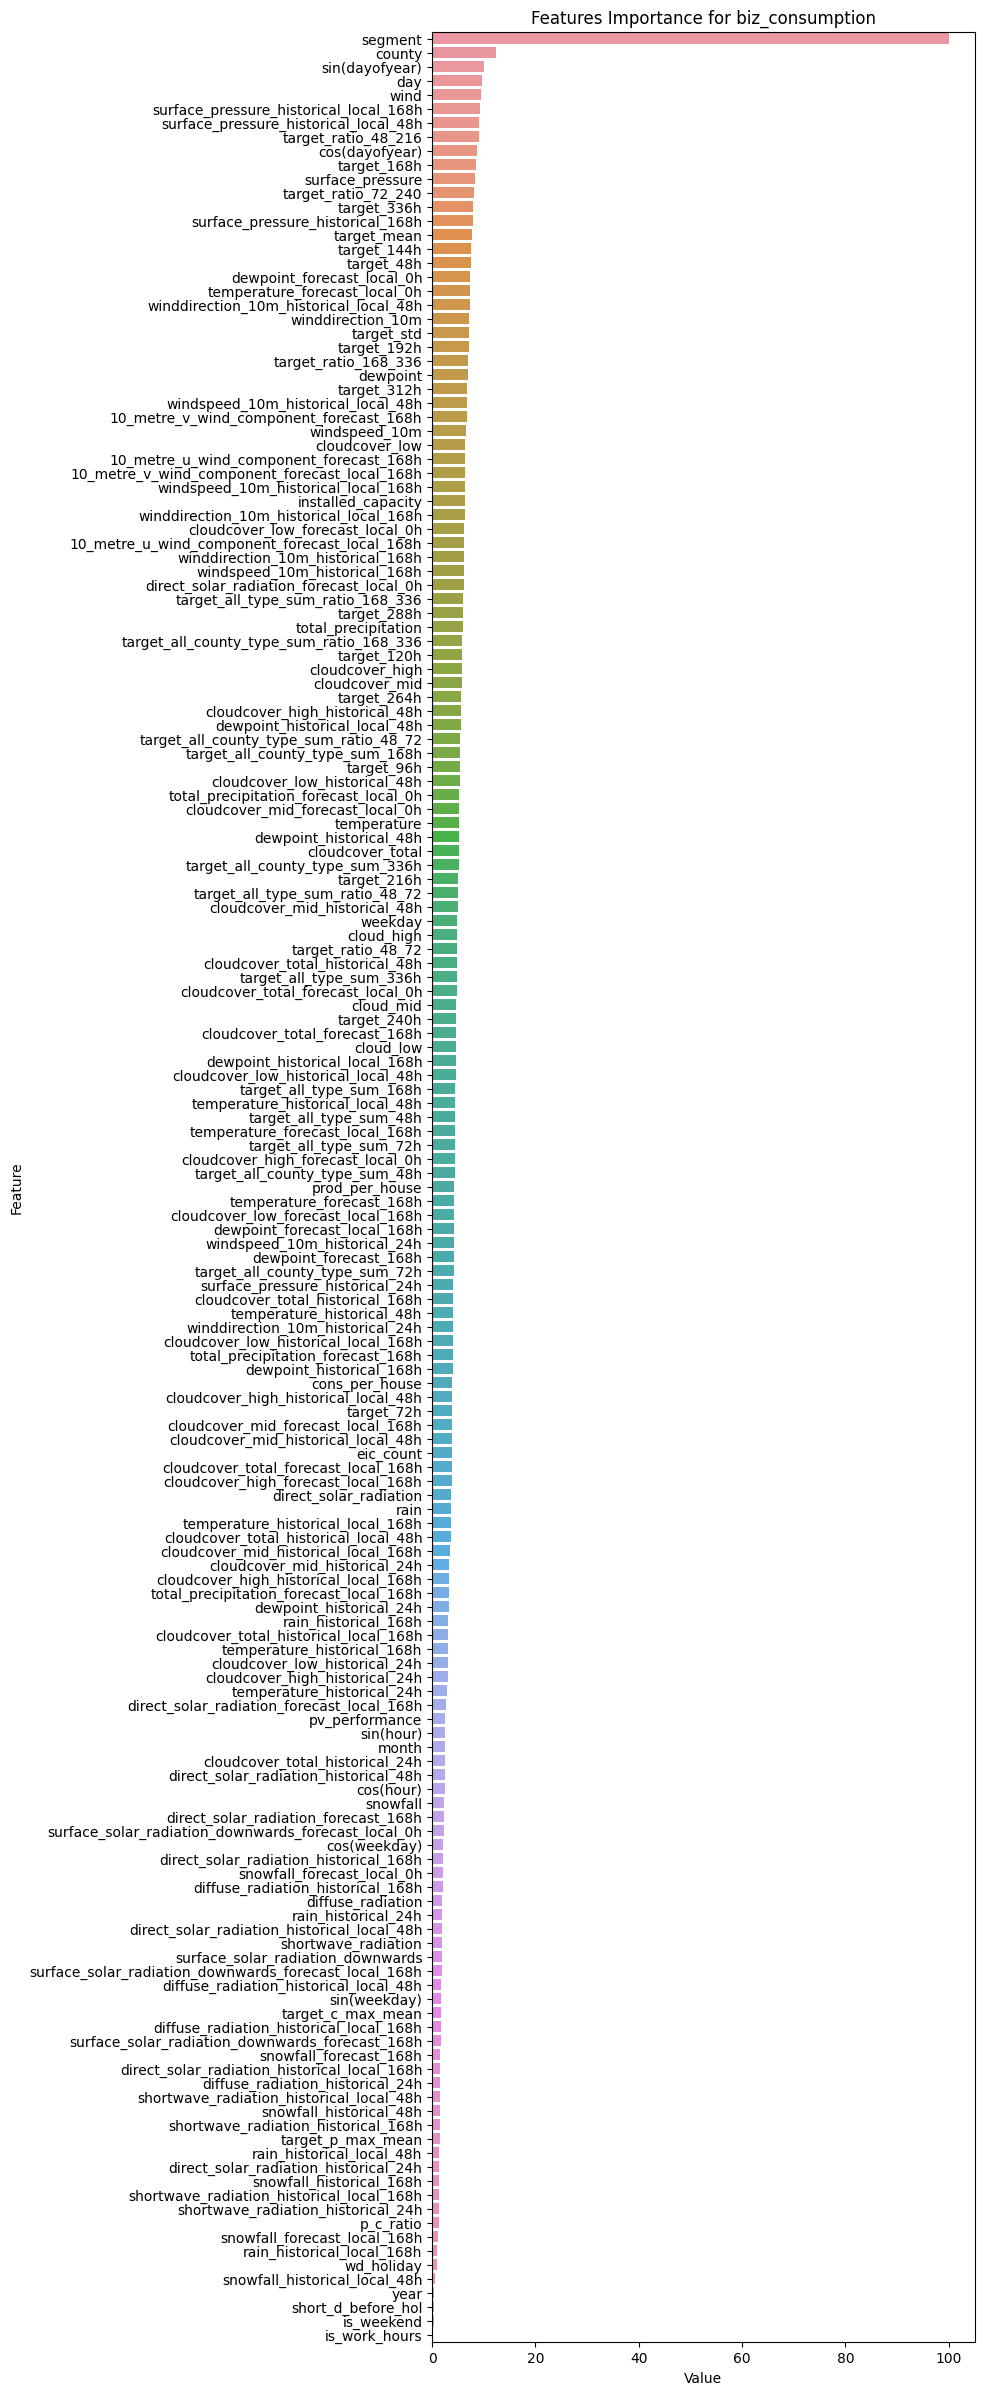

Getting CV with 800 estimators
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[None, None] [82.29, 30.56]
The 50 least useful features from best to worste for biz_production
['cloudcover_total_historical_local_168h', 'surface_pressure_historical_24h', 'rain', 'cloudcover_low_historical_24h', 'target_all_type_sum_72h', 'target_all_type_sum_48h', 'cloudcover_mid_historical_24h', 'cloudcover_high_historical_24h', 'dewpoint_forecast_168h', 'dewpoint_historical_168h', 'rain_historical_168h', 'direct_solar_radiation_forecast_local_168h', 'direct_solar_radiation_historical_48h', 'target_72h', 'cloudcover_total_historical_24h', 'shortwave_radiation', 'direct_solar_radiation_historical_168h', 'temperature_historical_1

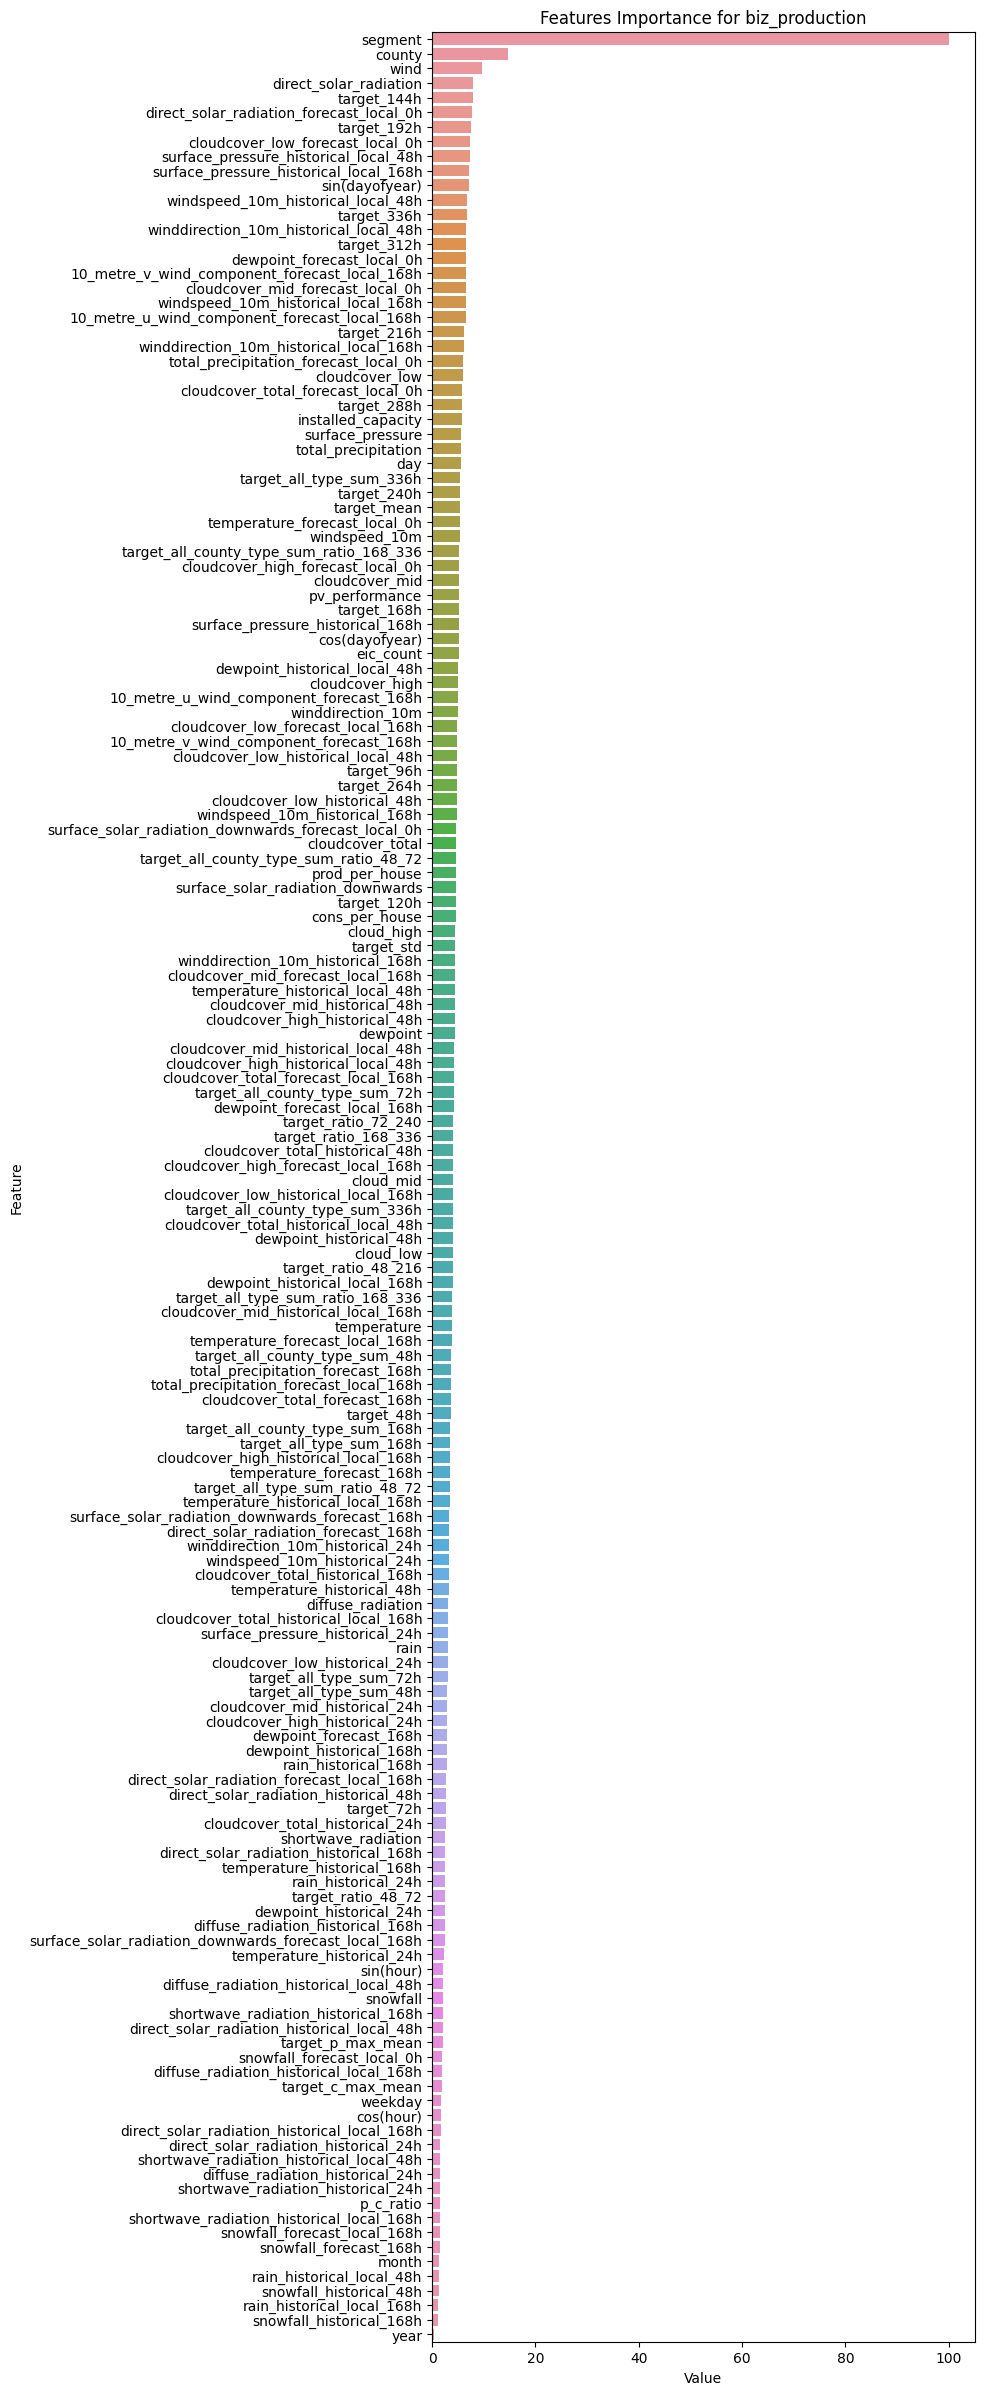

Getting CV with 800 estimators
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[None, None, None] [82.29, 30.56, 19.74]
The 50 least useful features from best to worste for home_consumption
['target_all_county_type_sum_48h', 'direct_solar_radiation_historical_48h', 'dewpoint_forecast_168h', 'cloudcover_total_historical_24h', 'dewpoint_historical_24h', 'direct_solar_radiation_forecast_local_168h', 'pv_performance', 'surface_solar_radiation_downwards_forecast_local_0h', 'dewpoint_historical_168h', 'temperature_historical_168h', 'direct_solar_radiation_historical_168h', 'diffuse_radiation_historical_168h', 'cos(hour)', 'diffuse_radiation', 'direct_solar_radiation_historical_local_48h', 'temperature_historical_24h

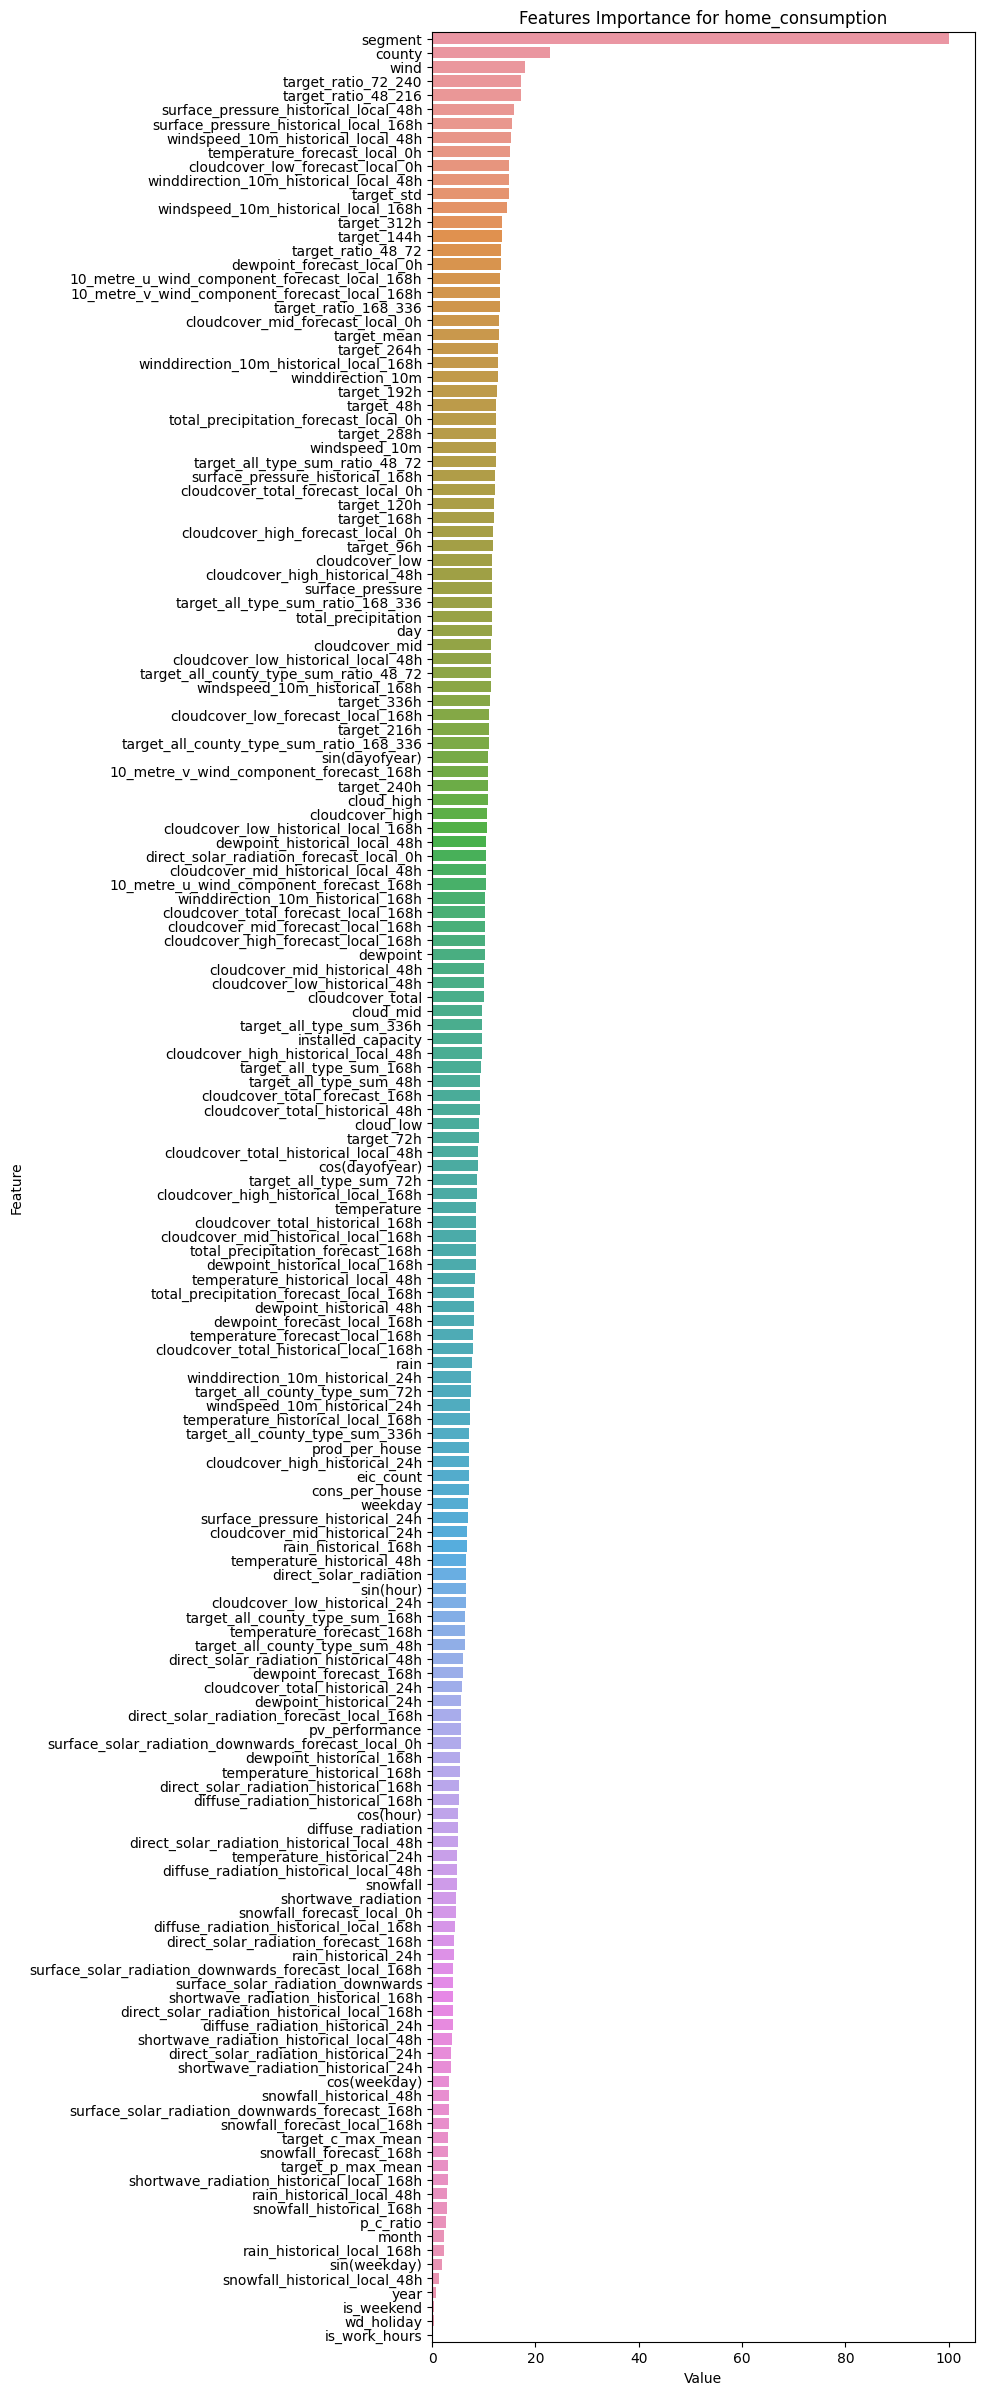

Getting CV with 800 estimators
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[None, None, None, None] [82.29, 30.56, 19.74, 30.3]
The 50 least useful features from best to worste for home_production
['rain_historical_168h', 'cloudcover_low_historical_24h', 'target_72h', 'diffuse_radiation', 'temperature_historical_48h', 'cloudcover_mid_historical_24h', 'direct_solar_radiation_historical_168h', 'direct_solar_radiation_forecast_local_168h', 'direct_solar_radiation_historical_48h', 'temperature_forecast_168h', 'surface_pressure_historical_24h', 'cloudcover_total_historical_24h', 'cloudcover_high_historical_24h', 'dewpoint_forecast_168h', 'diffuse_radiation_historical_168h', 'dewpoint_historical_168h', 'rain_his

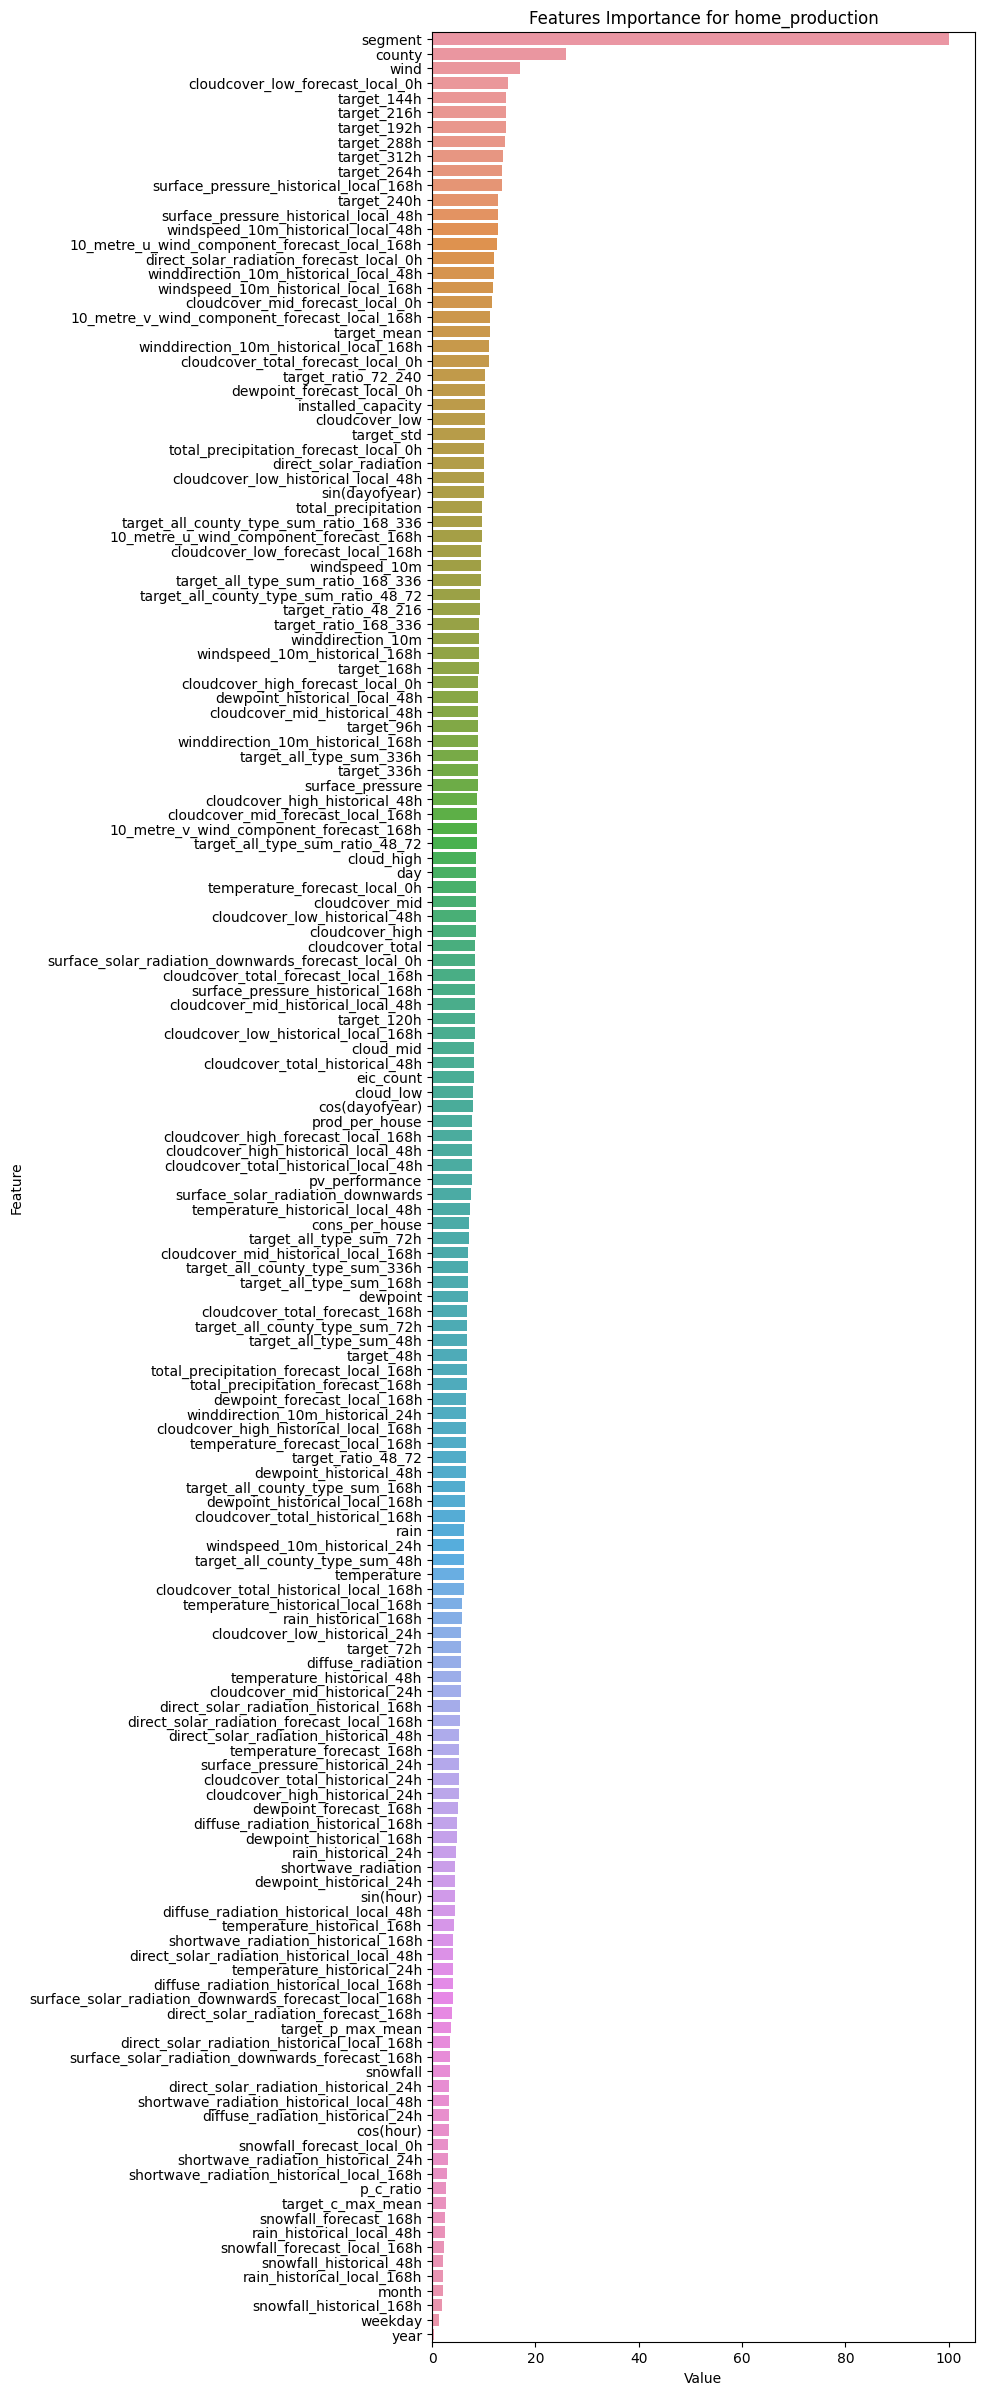

{'biz_consumption': 0.2709915616262741, 'biz_production': 0.2709915616262741, 'home_consumption': 0.22900843837372592, 'home_production': 0.22900843837372592}
{'2023-01-01': ([None, None, None, None], [82.29, 30.56, 19.74, 30.3])}
Getting CV with 800 estimators
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[None] [82.86]
Getting CV with 800 estimators
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[None, None] [82.86, 38.25]
Gettin

In [26]:
if cfg.val:
    folds = get_cv_folds(df_train_features)
    model = Model(cfg.model_parameters)
    print('Getting Cross Validation Scores')
    results = model.fit_with_cv(folds, early_stopping=False)
    print(results)
    

In [27]:
import optuna
if cfg.tune:
    print(f'Tuning {cfg.to_tune} with this notebook')
    def objective(trial):
        lgb_tune_params = dict(
            #learning_rate=trial.suggest_float("learning_rate", .006, .02, log=True),
            n_estimators = trial.suggest_int("n_estimators", 700, 1000),
            num_leaves = trial.suggest_int("num_leaves", 400, 600),
            #min_data_in_leaf=trial.suggest_int('min_data_in_leaf', 40, 80),
            #max_depth=trial.suggest_int("max_depth", 4, 20),
            #colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
            #colsample_bynode=trial.suggest_float("colsample_bynode", 0.5, 1),
            #lambda_l1=trial.suggest_float("lambda_l1", 2, 4),
            #lambda_l2 = trial.suggest_float('lambda_l2', 1,3),
            #subsample=trial.suggest_float("subsample", 0.5, 1.0),
            #reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
            #'reg_alpha': 2,
            #reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        )
        model = Model(lgb_tune_params)
        folds = get_cv_folds(df_train_features, cfg.to_tune)
        return model.fit_with_cv(folds, early_stopping=False)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=6)
    xgb_params = study.best_params


## Train Model

In [28]:
elapsed = (time.time() - start_time)/60
print(f'{elapsed:.2f} minutes have elapsed to this point in the notebook')

147.66 minutes have elapsed to this point in the notebook


In [29]:
model = Model(cfg.model_parameters)
model.fit(df_train_features)

n_estimators for biz_consumption:800
n_estimators for biz_production:950
n_estimators for home_consumption:800
n_estimators for home_consumption:800
num_leaves for biz_consumption:400
num_leaves for biz_production:690
num_leaves for home_consumption:400
num_leaves for home_consumption:680
[LightGBM] [Warning] lambda_l1 is set=4.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.0
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


In [30]:
#4.81 minutes splitting the training on different model splits to different cores with parallel/delayed
#1.29 doing the same with the 2xT4 GPUs, but something went wrong, regressor not fitted.
#1.19 soing the same with the P100, also says the regressor not fitted.
#1.27, with P100, no splitting
#1.99, no splitting, no GPU.    
#I'm not getting any benefit from splitting up the models, because LGBM under the hood is already maxing out the threads available

elapsed = (time.time() - start_time)/60
print(f'{elapsed:.2f} minutes have elapsed to this point in the notebook')

246.36 minutes have elapsed to this point in the notebook


# Submit API

In [31]:
env = enefit.make_env()
iter_test = env.iter_test() 

In [32]:
def is_prediction_needed(df_test):
    return not all(df_test['currently_scored'] == False)

eval_unscored = False

for (
    df_test, 
    df_new_target, 
    df_new_client, 
    df_new_historical_weather,
    df_new_forecast_weather, 
    df_new_electricity_prices, 
    df_new_gas_prices, 
    df_sample_prediction
) in iter_test:
    
    data_storage.update_with_new_data(
        df_new_client=df_new_client,
        df_new_gas_prices=df_new_gas_prices,
        df_new_electricity_prices=df_new_electricity_prices,
        df_new_forecast_weather=df_new_forecast_weather,
        df_new_historical_weather=df_new_historical_weather,
        df_new_target=df_new_target
    )
    
    if not is_prediction_needed(df_test) and not cfg.eval_unscored:
        df_sample_prediction['target'] = 0
        env.predict(df_sample_prediction)
        continue
    
    df_test = data_storage.preprocess_test(df_test)
    df_test_features = features_generator.generate_features(df_test)
    
    df_sample_prediction["target"] = model.predict(df_test_features)
    env.predict(df_sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [33]:
#Should be 3120 rows in the sample dataframe
if cfg.debug:
    print(df_sample_prediction.head(10))
    print(df_sample_prediction.tail(10))
    print(df_sample_prediction.describe())
    print('row_id:', df_sample_prediction['row_id'].dtype)
    print('target:', df_sample_prediction['target'].dtype)
    if df_sample_prediction['target'].isnull().any():
        print("There are still null or NaN values in the 'target columns.")
    else:
        print("There are no null or NaN values in the 'target' columns")
    if df_sample_prediction['row_id'].isnull().any():
        print("There are still null or NaN values in the 'target columns.")
    else:
        print("There are no null or NaN values in the 'row_id' columns")
    df_sample_prediction.to_csv('results.csv')